In [ ]:
# https://arxiv.org/pdf/2104.12259.pdf

In [ ]:
import torch
vers = torch.__version__
print("Torch vers: ", vers)

# PyG installation
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

import torch_geometric

Torch vers:  2.0.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from torch_geometric.datasets import UPFD
train_data = UPFD(root=".", name="poltifact", feature="bert", split="train")
test_data = UPFD(root=".", name="politifact", feature="bert", split="test")
print("Train Samples: ", len(train_data))
print("Test Samples: ", len(test_data))
# feature="content" --> Spacy Word2Vec + Profile features

In [ ]:
# News Propogation Graph
sample_id=1
train_data[sample_id].edge_index

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  15,  15,  17,  17,
          22,  22,  22,  22,  23,  26,  26,  26,  26,  26,  26,  26,  26,  27,
          27,  27,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,
          28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,
          28,  28,  28,  28,  28,  28,  28,  28,  30,  34,  34,  38,  38,  38,
          38,  39,  40,  57,  59,  65,  65,  65,  66,  68,  69,  77,  77,  79,
          79,  80,  83,  83,  83,  83,  84, 101, 110, 115, 116, 117],
        [  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
          15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
          29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  43,  44,
          45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  5

In [ ]:
import networkx as nx

# From PyG utils
def to_networkx(data, node_attrs=None, edge_attrs=None, to_undirected=False,
                remove_self_loops=False):
    if to_undirected:
        G = nx.Graph()
    else:
        G = nx.DiGraph()
    G.add_nodes_from(range(data.num_nodes))
    node_attrs, edge_attrs = node_attrs or [], edge_attrs or []
    values = {}
    for key, item in data(*(node_attrs + edge_attrs)):
        if torch.is_tensor(item):
            values[key] = item.squeeze().tolist()
        else:
            values[key] = item
        if isinstance(values[key], (list, tuple)) and len(values[key]) == 1:
            values[key] = item[0]
    for i, (u, v) in enumerate(data.edge_index.t().tolist()):
        if to_undirected and v > u:
            continue
        if remove_self_loops and u == v:
            continue
        G.add_edge(u, v)
        for key in edge_attrs:
            G[u][v][key] = values[key][i]
    for key in node_attrs:
        for i, feat_dict in G.nodes(data=True):
            feat_dict.update({key: values[key][i]})
    return G

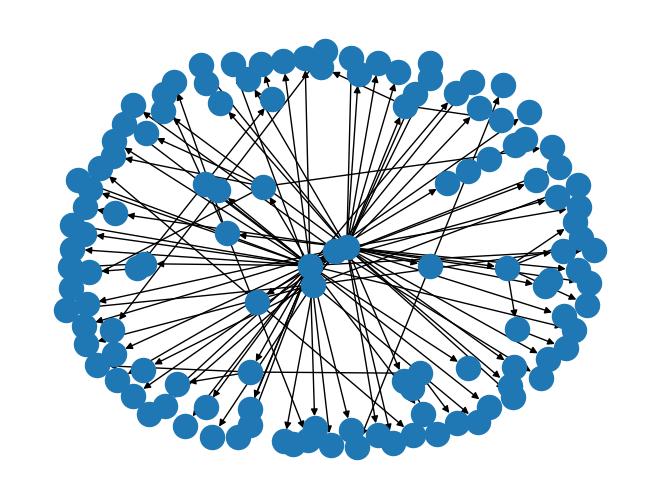

In [ ]:
nx.draw(to_networkx(train_data[sample_id]))

In [ ]:
# Node Fatures
print(train_data[sample_id].x.shape)
train_data[sample_id].x
# [ number of nodes, number of jnode feature]

torch.Size([125, 310])


tensor([[0.5220, 0.5120, 0.4817,  ..., 0.6874, 0.1023, 0.1529],
        [0.4610, 0.4544, 0.6279,  ..., 0.2055, 0.1667, 0.2500],
        [0.4461, 0.4728, 0.4978,  ..., 0.8356, 0.0556, 0.0000],
        ...,
        [0.5574, 0.4934, 0.5588,  ..., 0.3562, 0.0556, 0.2647],
        [0.5274, 0.5889, 0.4425,  ..., 0.9589, 0.1111, 0.1176],
        [0.5220, 0.5120, 0.4817,  ..., 0.6874, 0.1023, 0.1529]])

<AxesSubplot: >

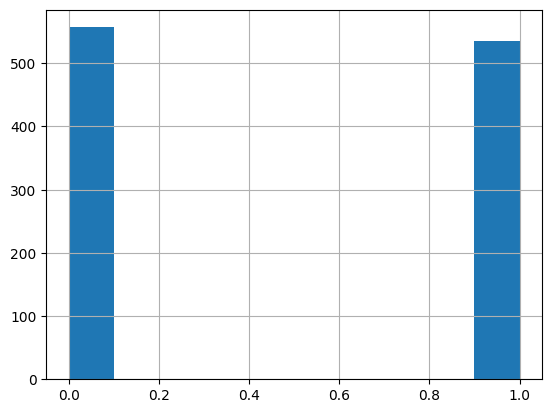

In [ ]:
import pandas as pd
labels = [data.y.item() for i, data in enumerate(train_data)]
df = pd.DataFrame(labels, columns=["Labels"])
df["Labels"].hist()

In [ ]:
# Data Loaders
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [ ]:
# Model training
# Because it is a directed graph, it will only share information from the root
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import GATConv
from torch.nn import Linear


class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        # Graph Convolutions
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)
        

        # Readout
        self.lin_news = Linear(in_channels, hidden_channels)
        self.lin0 = Linear(hidden_channels, hidden_channels)
        self.lin1 = Linear(2*hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # Graph Convolutions
        h = self.conv1(x, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        h = self.conv3(h, edge_index).relu()

        # Pooling
        h = gmp(h, batch)

        # Readout
        h = self.lin0(h).relu()

        # According to UPFD paper: Include raw word2vec embeddings of news 
        # This is done per graph in the batch
        root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0)
        # root is e.g. [   0,   14,   94,  171,  230,  302, ... ]
        news = x[root]
        news = self.lin_news(news).relu()
        
        out = self.lin1(torch.cat([h, news], dim=-1))
        return torch.sigmoid(out)

GNN(train_data.num_features, 256, 1)

GNN(
  (conv1): GATConv(310, 256, heads=1)
  (conv2): GATConv(256, 256, heads=1)
  (conv3): GATConv(256, 256, heads=1)
  (lin_news): Linear(in_features=310, out_features=256, bias=True)
  (lin0): Linear(in_features=256, out_features=256, bias=True)
  (lin1): Linear(in_features=512, out_features=1, bias=True)
)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(train_data.num_features, 256, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
loss_fnc = torch.nn.BCELoss()

def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs
        all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())

    # Calculate Metrics
    accuracy, f1 = metrics(all_preds, all_labels)

    return total_loss / len(test_loader.dataset), accuracy, f1


def metrics(preds, gts):
    preds = torch.round(torch.cat(preds))
    gts = torch.cat(gts)
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts)
    return acc, f1

In [ ]:
for epoch in range(80):
    train_loss = train(epoch)
    test_loss, test_acc, test_f1 = test(epoch)
    print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.2f} | '
          f'TestLoss: {test_loss:.2f} | TestAcc: {test_acc:.2f} | TestF1: {test_f1:.2f}')

Epoch: 00 |  TrainLoss: 0.77 | TestLoss: 0.70 | TestAcc: 0.50 | TestF1: 0.67
Epoch: 01 |  TrainLoss: 0.70 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 02 |  TrainLoss: 0.69 | TestLoss: 0.71 | TestAcc: 0.50 | TestF1: 0.67
Epoch: 03 |  TrainLoss: 0.70 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 04 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.67
Epoch: 05 |  TrainLoss: 0.69 | TestLoss: 0.70 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 06 |  TrainLoss: 0.68 | TestLoss: 0.68 | TestAcc: 0.50 | TestF1: 0.67
Epoch: 07 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 08 |  TrainLoss: 0.69 | TestLoss: 0.68 | TestAcc: 0.50 | TestF1: 0.67
Epoch: 09 |  TrainLoss: 0.69 | TestLoss: 0.68 | TestAcc: 0.86 | TestF1: 0.85
Epoch: 10 |  TrainLoss: 0.68 | TestLoss: 0.67 | TestAcc: 0.52 | TestF1: 0.07
Epoch: 11 |  TrainLoss: 0.67 | TestLoss: 0.67 | TestAcc: 0.50 | TestF1: 0.67
Epoch: 12 |  TrainLoss: 0.68 | TestLoss: 0.67 | TestAcc: 0.50 | TestF1: 0.01

In [ ]:
for data in test_loader:
    data = data.to(device)
    pred = model(data.x, data.edge_index, data.batch)
    df = pd.DataFrame()
    df["pred_logit"] = pred.detach().numpy()[:,0]
    df["pred"] = torch.round(pred).detach().numpy()[:,0]
    df["true"] = data.y.numpy()
    print(df.head(10))
    break

   pred_logit  pred  true
0    0.859680   1.0     1
1    0.765499   1.0     1
2    0.289115   0.0     0
3    0.730609   1.0     1
4    0.051945   0.0     0
5    0.228885   0.0     0
6    0.136109   0.0     0
7    0.931150   1.0     1
8    0.059715   0.0     0
9    0.134473   0.0     0
